### Customer Churn Prediction for Telecom Company

#### Importing the necessary modules

In [2]:
import pandas as pd
import numpy as np
import datetime
from datetime import date
import time
import phik

import matplotlib as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px 
import plotly.graph_objects as go
from os import path

from scipy import stats as st
import math as mth
from xgboost import  XGBClassifier, plot_importance
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn import set_config
from sklearn.utils import shuffle
from numpy.random import RandomState
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline as sk_Pipeline
from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer

from catboost import Pool, CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.3f}'.format)

In [4]:

path_local = '/Users/kbzunder/Downloads/final_provider/'

if path.exists(path_local):
    contracts = pd.read_csv(path_local +'contract.csv')
    internet  = pd.read_csv(path_local + 'internet.csv')
    personal = pd.read_csv(path_local +'personal.csv')
    phone = pd.read_csv(path_local +'phone.csv')
else:
    path_train = '/datasets/final_provider/'
    contracts = pd.read_csv(path_train + 'contract.csv')
    internet =  pd.read_csv(path_train + 'internet.csv')
    personal = pd.read_csv(path_train + 'personal.csv')
    phone = pd.read_csv(path_train + 'phone.csv')


In [5]:
contracts.head(20)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.850,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.950,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.850,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.300,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.700,151.65
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.650,820.5
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.100,1949.4
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.750,301.9
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.800,3046.05
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.150,3487.95


In [6]:
contracts[contracts['EndDate'] == 'No']['EndDate'].count()

5174

In [7]:
contracts.duplicated().sum()

0

In [8]:
contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [9]:
fig = px.histogram(contracts, x='MonthlyCharges') 
fig.show()

In [10]:
contracts.describe()

,MonthlyCharges
count,7043.000
mean,64.762
std,30.090
min,18.250
25%,35.500
50%,70.350
75%,89.850
max,118.750


#### The target feature in the project is terminating or saving the contract ('EndDate' == 'No'), in our dataset of 7043 clients, 5174 or 73 percent continue to be the company's customers - the data is unbalanced, this moment will have to be taken into account when preparing features.

In [11]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [27]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [28]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [29]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [30]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [31]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


### First glance at data
1. Data is provided in  4 datasets, no nulls
2. Each dataset has a different number of observations
3. Only columns `MonthlyCharges` , `TotalCharges` contain numerical information about revenue from the client
4. The data must be combined into one dataframe using the `customerID` key

### The project quality metric is ROC-AUC (resistant to outliers), we will additionally include F1 score and accuracy in the calculations.

[1. Loading the data](#data_download)  
[2. Data preprocessing and cleaning](#data_preprocessing)  
[3. Merging data, preparing data for training](#merging)  
[4. Choice of learning model ](#model_celection)  
[5. Testing model on test data](#model_testing)  
[6. Feature importance analysis](#feature_selection)  
[7. Conclusions](#Conclusion)  


<a id='data_download'></a>
### 1. Loading the data

<a id='data_preprocessing'></a>
### 2. Data preprocessing and cleaning

####  contracts dataset

In [13]:
contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Renaming columns, changing data types of  `BeginDate`, `EndDate` from string to datetime,  in  `TotalChanges` - to float64 

In [14]:
contracts_columns = ['customer_id','begin_date', 'end_date','type', 'paperless_billing', 'payment_mode', 'monthly_charges', 'total_charges']

In [15]:
contracts.columns = contracts_columns

In [16]:
contracts.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_mode,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.850,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.950,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.850,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.300,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.700,151.65


In [17]:
contracts['begin_date'] = pd.to_datetime(contracts['begin_date'])

In [18]:
# Replace all string values 'No' in the 'end_data' column with the data collection end date - February 1, 2020
contracts.loc[contracts['end_date']=='No', 'end_date'] = '2020-02-01'

In [19]:
contracts['end_date'] = pd.to_datetime(contracts['end_date'])

In [20]:
contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_mode       7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   object        
dtypes: datetime64[ns](2), float64(1), object(5)
memory usage: 440.3+ KB


In [21]:
contracts['total_charges'] =  pd.to_numeric(contracts['total_charges'], errors='coerce')

In [22]:
contracts[contracts['total_charges'].isna()]

,customer_id,begin_date,end_date,type,paperless_billing,payment_mode,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.550,NaN
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.250,NaN
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.850,NaN
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.750,NaN
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.050,NaN
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.850,NaN
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.350,NaN
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.000,NaN
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.700,NaN
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.350,NaN


The gaps in the `total_charges` column are due to the fact that these are new customers who have just signed a contract and have not had time to generate income, fill in these gaps 0

In [23]:
contracts['total_charges'] = contracts['total_charges'].fillna(0)

In [24]:
contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_mode       7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


In [25]:
contracts.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_mode,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.850,29.850
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.950,1889.500
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.850,108.150
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.300,1840.750
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.700,151.650


In [26]:
contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_mode       7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


In [27]:
# Adding a column with contract duration in months
contracts['contract_length_mnths'] = (contracts['end_date'] - contracts['begin_date']).dt.days/ 30

In [28]:
# Adding the  year of the contract start
contracts['begin_year'] = contracts['begin_date'].dt.year

In [29]:
# Adding the month of the  contract start
contracts['begin_month'] = contracts['begin_date'].dt.month

In [30]:
contracts.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_mode,monthly_charges,total_charges,contract_length_mnths,begin_year,begin_month
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.850,29.850,1.033,2020,1
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.950,1889.500,34.533,2017,4
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.850,108.150,2.033,2019,10
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.300,1840.750,45.700,2016,5
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.700,151.650,2.033,2019,9


In [35]:
# Adding  the target column 'quit' - whether the user is a current client of the company (0) or a departed one (1):
contracts.loc[contracts['end_date']== np.datetime64('2020-02-01'), 'quit'] = 0

In [36]:
contracts.loc[contracts['end_date'] != np.datetime64('2020-02-01'), 'quit'] = 1

In [37]:
contracts['quit'] = contracts['quit'].astype(int)

In [38]:
contracts.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_mode,monthly_charges,total_charges,contract_length_mnths,begin_year,begin_month,quit
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.850,29.850,1.033,2020,1,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.950,1889.500,34.533,2017,4,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.850,108.150,2.033,2019,10,1
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.300,1840.750,45.700,2016,5,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.700,151.650,2.033,2019,9,1


In [39]:
# check for duplicates
contracts.duplicated().sum()

0

In [41]:
fig = px.box(contracts, x = 'total_charges', title='Range of total spending')

fig.show()

There are no more outliers, most of the clients bring up to 4 thousand rubles, and the median income is about 1400 rubles

In [42]:
fig = px.histogram(contracts, x='contract_length_mnths', color ='quit', title='Distribution of contract duration in months')
fig.show()

In [43]:
fig1 = px.histogram(contracts.query('quit==1'), x='contract_length_mnths', title='Distribution of departed clients by contract length')
fig2 = px.histogram(contracts.query('quit==0'), x='contract_length_mnths', title = 'Distribution of active clients by contract length' )
fig1.show()
fig2.show()

We see that most of those who leave leave quickly, in 1-3 months, and among the active clients there are many old-timers who have been with the company for more than 5 years

#### Датасет internet

In [60]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [61]:
inter_columns = ['customer_id', 'internet_service','online_security','online_backup','device_protection','tech_support','streaming_tv','streaming_movies']

In [62]:
internet.columns = inter_columns

In [63]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [64]:
internet.duplicated().sum()

0

In [65]:
internet['internet_service'].value_counts()

Fiber optic    3096
DSL            2421
Name: internet_service, dtype: int64

There are fewer observations in the `internet` dataset than in contracts, not all users have a contract with Internet services, there are no gaps and duplicates in the dataset, users are almost equally distributed by type of Internet service (Fiber optic and DSL)

#### Датасет personal

In [66]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [44]:
person_columns = ['customer_id','gender','senior_citizen','partner','dependants']

In [45]:
personal.columns = person_columns

In [46]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependants      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [47]:
personal.duplicated().sum()

0

In [48]:
personal['gender'].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

In [49]:
fig = px.bar(personal.groupby('gender', as_index=False).agg({'customer_id':'nunique'})\
    .rename(columns={'customer_id':'customers'}), y='customers', x='gender', title='Distribution of users by gender')
fig.show()

In [73]:
personal['dependants'].value_counts()

No     4933
Yes    2110
Name: dependants, dtype: int64

In [50]:
fig = px.bar(personal.groupby('dependants', as_index=False).agg({'customer_id':'nunique'})\
    .rename(columns={'customer_id':'customers'}), y='customers', x='dependants', title='Distribution of users by having dependants')
fig.show()

In [51]:
personal['partner'].value_counts()

No     3641
Yes    3402
Name: partner, dtype: int64

In [52]:
fig = px.bar(personal.groupby('partner', as_index=False).agg({'customer_id':'nunique'})\
    .rename(columns={'customer_id':'customers'}), y='customers', x='partner', title='Distribution of users by the presence of a partner')
fig.show()

In [53]:
personal['senior_citizen'].value_counts()

0    5901
1    1142
Name: senior_citizen, dtype: int64

In [54]:
fig = px.bar(personal.groupby('senior_citizen', as_index=False).agg({'customer_id':'nunique'})\
    .rename(columns={'customer_id':'customers'}), y='customers', x='senior_citizen',\
         title='Distribution of users into users before and after retirement age')
fig.show()

Among clients, men and women, with and without partners, are approximately equally distributed, free from dependents and non-pensioners predominate

The number of rows in the dataset matches `contracts`, no duplicates or gaps

####  phone dataset

In [55]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [56]:
phone = phone.rename(columns={'customerID':'customer_id','MultipleLines':'multiple_lines'})

In [57]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [58]:
phone.duplicated().sum()

0

In [59]:
phone['multiple_lines'].value_counts()

No     3390
Yes    2971
Name: multiple_lines, dtype: int64

In [60]:
fig = px.bar(phone.groupby('multiple_lines', as_index=False).agg({'customer_id':'nunique'})\
    .rename(columns={'customer_id':'customers'}), y='customers', x='multiple_lines',\
         title='Distribution of users by availability of multi-channel telephony')
fig.show()

There are fewer lines in the `phone` dataset, not all users have information on several telephone lines, there are no duplicates or gaps, about half of the users have several telephone lines

<a id='merging'></a>
### 3. Merging data, preparing data for training

In [84]:
# Merge the datasets into one,  left join  the rest of the datasets to the contracts
merged = contracts\
    .merge(personal, on='customer_id', how='left' )\
    .merge(internet, on='customer_id', how='left')\
    .merge(phone, on='customer_id', how='left')

In [85]:
merged.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_mode,monthly_charges,total_charges,contract_length_mnths,begin_year,...,partner,dependants,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.850,29.850,1.033,2020,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.950,1889.500,34.533,2017,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.850,108.150,2.033,2019,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.300,1840.750,45.700,2016,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.700,151.650,2.033,2019,...,No,No,Fiber optic,No,No,No,No,No,No,No


In [86]:
merged.isna().sum().sort_values(ascending=False)

streaming_movies         1526
streaming_tv             1526
tech_support             1526
device_protection        1526
online_backup            1526
online_security          1526
internet_service         1526
multiple_lines            682
begin_date                  0
dependants                  0
partner                     0
senior_citizen              0
customer_id                 0
quit                        0
begin_month                 0
begin_year                  0
contract_length_mnths       0
total_charges               0
monthly_charges             0
payment_mode                0
paperless_billing           0
type                        0
end_date                    0
gender                      0
dtype: int64

In [87]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   customer_id            7043 non-null   object        
 1   begin_date             7043 non-null   datetime64[ns]
 2   end_date               7043 non-null   datetime64[ns]
 3   type                   7043 non-null   object        
 4   paperless_billing      7043 non-null   object        
 5   payment_mode           7043 non-null   object        
 6   monthly_charges        7043 non-null   float64       
 7   total_charges          7043 non-null   float64       
 8   contract_length_mnths  7043 non-null   float64       
 9   begin_year             7043 non-null   int64         
 10  begin_month            7043 non-null   int64         
 11  quit                   7043 non-null   int64         
 12  gender                 7043 non-null   object        
 13  sen

Gaps in the final dataset are related to the lack of data - the client does not have these services, I consider it correct to fill them with the value 'No'

In [88]:
merged = merged.fillna('No')

In [89]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   customer_id            7043 non-null   object        
 1   begin_date             7043 non-null   datetime64[ns]
 2   end_date               7043 non-null   datetime64[ns]
 3   type                   7043 non-null   object        
 4   paperless_billing      7043 non-null   object        
 5   payment_mode           7043 non-null   object        
 6   monthly_charges        7043 non-null   float64       
 7   total_charges          7043 non-null   float64       
 8   contract_length_mnths  7043 non-null   float64       
 9   begin_year             7043 non-null   int64         
 10  begin_month            7043 non-null   int64         
 11  quit                   7043 non-null   int64         
 12  gender                 7043 non-null   object        
 13  sen

In [88]:
#Deleting columns not needed for analysis: customer_id, begin_date, end_date

In [90]:
merged = merged.drop(['customer_id', 'begin_date','end_date'], axis=1)

After long experiments with columns, I came to the conclusion that logistic regression does not work very well, correlation does not have a particularly strong effect on the quality of models, I decided to leave the columns as much as possible

In [76]:

#Checking for features correlation
#correlation = merged.phik_matrix()

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'contract_length_mnths', 'begin_year', 'begin_month', 'quit', 'senior_citizen']


In [77]:
#correlation[correlation > 0.7].fillna('')

,type,paperless_billing,payment_mode,monthly_charges,total_charges,contract_length_mnths,begin_year,begin_month,quit,gender,...,partner,dependants,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
type,1.000,,,,,,,,,,...,,,,,,,,,,
paperless_billing,,1.000,,,,,,,,,...,,,,,,,,,,
payment_mode,,,1.000,,,,,,,,...,,,,,,,,,,
monthly_charges,,,,1.000,0.763,,,,,,...,,,0.919,,,,,0.835,0.833,
total_charges,,,,0.763,1.000,0.842,0.733,,,,...,,,,,,,,,,
contract_length_mnths,,,,,0.842,1.000,0.927,,,,...,,,,,,,,,,
begin_year,,,,,0.733,0.927,1.000,,,,...,,,,,,,,,,
begin_month,,,,,,,,1.000,,,...,,,,,,,,,,
quit,,,,,,,,,1.000,,...,,,,,,,,,,
gender,,,,,,,,,,1.000,...,,,,,,,,,,


In [78]:
# We can remove one of the two columns whose correlation is higher than 0.7, remove the columns 'total_charges', 'streaming_movies', 'streaming_tv', 'contract_length_mnths' , ,
# 'internet_service'
#merged = merged.drop(columns=['streaming_movies','streaming_tv','total_charges','internet_service','contract_length_mnths'], axis=1)



In [91]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   type                   7043 non-null   object 
 1   paperless_billing      7043 non-null   object 
 2   payment_mode           7043 non-null   object 
 3   monthly_charges        7043 non-null   float64
 4   total_charges          7043 non-null   float64
 5   contract_length_mnths  7043 non-null   float64
 6   begin_year             7043 non-null   int64  
 7   begin_month            7043 non-null   int64  
 8   quit                   7043 non-null   int64  
 9   gender                 7043 non-null   object 
 10  senior_citizen         7043 non-null   int64  
 11  partner                7043 non-null   object 
 12  dependants             7043 non-null   object 
 13  internet_service       7043 non-null   object 
 14  online_security        7043 non-null   object 
 15  onli

In [92]:
# To avoid data leakage, removing the begin_gear column
features = merged.drop(columns=['quit','begin_year'], axis=1)
target = merged['quit']

In [93]:
features.head()

,type,paperless_billing,payment_mode,monthly_charges,total_charges,contract_length_mnths,begin_month,gender,senior_citizen,partner,dependants,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,Month-to-month,Yes,Electronic check,29.850,29.850,1.033,1,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No
1,One year,No,Mailed check,56.950,1889.500,34.533,4,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,Month-to-month,Yes,Mailed check,53.850,108.150,2.033,10,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,One year,No,Bank transfer (automatic),42.300,1840.750,45.700,5,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No
4,Month-to-month,Yes,Electronic check,70.700,151.650,2.033,9,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [94]:
# Разделим данные на обучающую и тестовую выборку в отношении 75:25
features_train, features_test, target_train, target_test \
    = train_test_split(features, target,  train_size=0.75, random_state=101022, shuffle=target)

In [95]:
(features_train.shape, target_train.shape)

((5282, 19), (5282,))

In [96]:
(features_test.shape, target_test.shape)

((1761, 19), (1761,))

#### Making pipeline

In [97]:
state = RandomState(101022)

In [98]:
classifiers = [
  LogisticRegression(random_state=state),
  RandomForestClassifier(random_state=state),
  XGBClassifier(random_state=state),
  AdaBoostClassifier(),
  CatBoostClassifier(eval_metric='AUC')
]

In [99]:
roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True,
                             needs_threshold=True)

In [100]:
class_prarms = [
    { 'class__solver' : ['lbfgs', 'liblinear'],'class__penalty' :['l1','l2','none'], 'class__C': np.arange(0.5,1.5,0.25), 'class__fit_intercept' : [True, False] },
    {'class__max_features': ['auto','log2','sqrt', 'None'],'class__criterion' : ['gini', 'log_loss', 'entropy'], 'class__n_estimators' : range(10,1000,10), 'class__max_depth' : range(1,50), 'class__min_samples_split': range(1,10), 'class__min_samples_leaf': range(1,10)},
    {'class__eta': np.arange(0.01, 0.2, 0.01), 'class__max_depth': range(3,20), 'class__gamma' : np.arange(0,1,0.001),'class__learning_rate': np.arange(0.01, 1, 0.001), 'class__booster':['gbtree','gblinear'], 'class__n_estimators': range(10,1000,5)},
    {'class__n_estimators' : range(10,1000,10), 'class__learning_rate' : np.arange(0.1, 1, 0.01),'class__algorithm' : ['SAMME','SAMME.R'] },
    {'class__learning_rate': np.arange(0,1,0.001), 'class__iterations': range(5,100,1), 'class__depth': range(2,20), 'class__l2_leaf_reg':range(2,11), 'class__random_strength': range(0,11)}
]
cv = KFold(n_splits=10, shuffle=True, random_state=state)

In [101]:
features.head()

,type,paperless_billing,payment_mode,monthly_charges,total_charges,contract_length_mnths,begin_month,gender,senior_citizen,partner,dependants,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,Month-to-month,Yes,Electronic check,29.850,29.850,1.033,1,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No
1,One year,No,Mailed check,56.950,1889.500,34.533,4,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,Month-to-month,Yes,Mailed check,53.850,108.150,2.033,10,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,One year,No,Bank transfer (automatic),42.300,1840.750,45.700,5,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No
4,Month-to-month,Yes,Electronic check,70.700,151.650,2.033,9,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [102]:
cat_col = ['paperless_billing','payment_mode','gender','senior_citizen',\
    'partner','dependants','online_backup','online_security','device_protection',\
    'tech_support', 'multiple_lines','type','streaming_movies','streaming_tv','internet_service']

In [103]:
m_col = ['monthly_charges', 'begin_month','total_charges','contract_length_mnths']

In [104]:
features.columns

Index(['type', 'paperless_billing', 'payment_mode', 'monthly_charges',
       'total_charges', 'contract_length_mnths', 'begin_month', 'gender',
       'senior_citizen', 'partner', 'dependants', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines'],
      dtype='object')

In [105]:
t = [('cat', OneHotEncoder(), cat_col), ('num', StandardScaler(), m_col)]
col_transform = ColumnTransformer(transformers=t)


In [106]:
from scipy import rand


best_esimators = []
best_score = []
for i, classifier in enumerate(classifiers):
    steps = [
       ('prep',col_transform),
       ('smote', SMOTE(random_state=state)),
       ('selector', VarianceThreshold()),
       ('class', classifier)
    ]
    pipeline = Pipeline(steps)
    grid = RandomizedSearchCV(pipeline,class_prarms[i] , scoring=roc_auc_scorer, cv=cv, n_iter=10)
    grid.fit(features_train, target_train)
    print(classifier, grid.best_estimator_)
    best_esimators.append(grid.best_estimator_)
    best_score.append(grid.best_score_)
   

LogisticRegression(random_state=RandomState(MT19937) at 0x29FC0B040) Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['paperless_billing',
                                                   'payment_mode', 'gender',
                                                   'senior_citizen', 'partner',
                                                   'dependants',
                                                   'online_backup',
                                                   'online_security',
                                                   'device_protection',
                                                   'tech_support',
                                                   'multiple_lines', 'type',
                                                   'streaming_movies',
                                                   'streaming_tv',
                                              

In [107]:
best_score

[0.8481907372894947,
 0.8822920139041756,
 0.9940256995262338,
 0.8829621922548355,
 0.9897904241976407]

<a id='model_testing'></a>
### 5. Testing model on test data

In [108]:
from sklearn.metrics import accuracy_score


r_result = []
f_result = []
a_result = []
for estimator in best_esimators:
    estimator.fit(features_train, target_train)
    predicted = estimator.predict(features_test)
    r_score = roc_auc_score(target_test, predicted)
    accuracy = accuracy_score(target_test, predicted)
    f1 = f1_score(target_test, predicted)
    r_result.append(r_score)
    f_result.append(f1)
    a_result.append(accuracy)

0:	total: 6.6ms	remaining: 284ms
1:	total: 13.7ms	remaining: 287ms
2:	total: 20.2ms	remaining: 276ms
3:	total: 27.5ms	remaining: 275ms
4:	total: 33.5ms	remaining: 262ms
5:	total: 39.4ms	remaining: 250ms
6:	total: 45.8ms	remaining: 242ms
7:	total: 52.4ms	remaining: 236ms
8:	total: 59.7ms	remaining: 232ms
9:	total: 65.1ms	remaining: 221ms
10:	total: 71.1ms	remaining: 213ms
11:	total: 76.8ms	remaining: 205ms
12:	total: 83.4ms	remaining: 199ms
13:	total: 88.4ms	remaining: 189ms
14:	total: 95.1ms	remaining: 184ms
15:	total: 100ms	remaining: 175ms
16:	total: 107ms	remaining: 169ms
17:	total: 114ms	remaining: 165ms
18:	total: 120ms	remaining: 158ms
19:	total: 137ms	remaining: 164ms
20:	total: 200ms	remaining: 219ms
21:	total: 210ms	remaining: 210ms
22:	total: 215ms	remaining: 197ms
23:	total: 222ms	remaining: 185ms
24:	total: 229ms	remaining: 174ms
25:	total: 236ms	remaining: 163ms
26:	total: 248ms	remaining: 156ms
27:	total: 254ms	remaining: 145ms
28:	total: 264ms	remaining: 137ms
29:	total:

In [111]:
estimator = best_esimators[2]
estimator.fit(features_train, target_train)
predicted = estimator.predict(features_test)
r_score = roc_auc_score(target_test, predicted)
accuracy = accuracy_score(target_test, predicted)
f1 = f1_score(target_test, predicted)

In [112]:
result_data_one = pd.DataFrame({'Модель': classifiers[2], 'roc_auc': [r_score], 'accuracy': [accuracy], 'f1': [f1]})

In [113]:
result_data_one

,Модель,roc_auc,accuracy,f1
0,"XGBClassifier(base_score=None, booster=None, c...",0.973,0.985,0.972


In [114]:
best_esimators[2]

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['paperless_billing',
                                                   'payment_mode', 'gender',
                                                   'senior_citizen', 'partner',
                                                   'dependants',
                                                   'online_backup',
                                                   'online_security',
                                                   'device_protection',
                                                   'tech_support',
                                                   'multiple_lines', 'type',
                                                   'streaming_movies',
                                                   'streaming_tv',
                                                   'internet_service']),
                                                 ('num', StandardScaler(),
                                                  ['monthly_char...
                               eval_metric=None, gamma=0.176, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.8209999999999993, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=4, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=560, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=189388003,
                               reg_alpha=0, ...))])

In [120]:
best_esimators[2][3]

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.13,
              eval_metric=None, gamma=0.176, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.8209999999999993, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=4, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=560, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=189388003, reg_alpha=0, ...)

<a id='feature_selection'></a>
### 6. Feature importance

In [132]:
features_train_enc = pd.get_dummies(features_train, drop_first=True)

In [133]:
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train_enc)

[0.00852869 0.00777289 0.03311843 0.03208709 0.0106718  0.12677702
 0.16526222 0.01996835 0.00154618 0.0292342  0.00434801 0.00578295
 0.00344198 0.01267254 0.33205944 0.13433479 0.02163319 0.0035892
 0.00400021 0.00873483 0.00102305 0.02635324 0.0070597 ]


<AxesSubplot: >

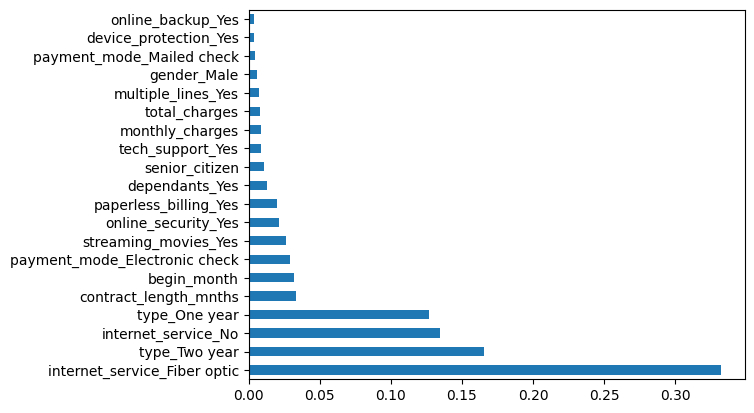

In [138]:
model = XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.13,
              eval_metric=None, gamma=0.176, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.8209999999999993, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=4, max_leaves=0,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=560, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=189388003, reg_alpha=0)
model.fit(features_train_scaled, target_train)
print(model.feature_importances_)
# plot
feat_importances = pd.Series(model.feature_importances_, index=features_train_enc.columns)
feat_importances.nlargest(20).plot(kind='barh')

The XGBoost model detected the type of Internet connection, the type of contract, and the absence of an Internet contract as the most important features that influenced the departure of the client.

<a id='Conclusion'></a>
### 7.  Conclusion


1. Conducted training, tuning and testing of the classification model to determine users who are ready to churn 
2. The best model by `ROC-AUC` metric is `XGBoostClassifer`, roc-auc achieved `0.97` on the test sample, accuracy and f1 measure are also the best for this model